In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats

In [2]:
import glob

all_files = glob.glob('../nov2018.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['Speed'] = df['Speed'][df['Speed'] !=  'Bronx'].astype(float)
    df['DataAsOf'] = df['DataAsOf'][df['Speed'] !=  'Bronx'].astype(str)
    df = df[['Speed','DataAsOf','Id']]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

/home/smr1020/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [3]:
df = df.dropna()
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])

In [4]:
df['Speed_norm'] = 0
for group in df.groupby('Id'):
    df_tem = group[1]
    df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
    df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']

<ipython-input-4-a9b855d8c37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
<ipython-input-4-a9b855d8c37e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']
<ipython-input-4-a9b855d8c37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [5]:
df_weather = pd.read_csv('../2285527.csv')
df_weather = df_weather[df_weather['STATION'] == 'USW00094728']
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
df_weather = df_weather.set_index('DATE')

In [6]:
df

,Speed,DataAsOf,Id,Speed_norm
0,5.59,2018-11-01 02:58:28,1,-1.060877
1,3.72,2018-11-01 02:58:28,106,-0.626531
2,47.22,2018-11-01 02:58:15,110,0.920393
3,36.66,2018-11-01 02:58:16,119,1.910969
4,0.00,2018-11-01 02:58:16,124,-2.433924
...,...,...,...,...
1150287,0.00,2018-11-30 23:58:20,445,NaN
1150288,21.12,2018-11-30 23:58:22,448,-0.307235
1150289,42.25,2018-11-30 23:58:22,450,0.694977
1150290,47.22,2018-11-30 23:58:18,451,0.501404


In [44]:
def plot_traffic_speed(df,df_weather,start,end,figsize = (10,3),ticks='1D'):

    plt.figure(dpi=300,figsize=figsize)
    dates = pd.date_range(start=start,end=end,freq=ticks)

    mask = (df['DataAsOf'] > pd.to_datetime(start)) & (df['DataAsOf'] <= pd.to_datetime(end))

    df_filtered = df[mask]

    df_list = []


    for group in df_filtered.groupby('Id'):
        df_tem = group[1].set_index('DataAsOf')
        plt.plot(df_tem.index,df_tem['Speed_norm'],alpha=0.05,color='k')
        plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=5)

        df_i = df_tem.rename(columns = {'Speed_norm':df_tem['Id'][0]})[df_tem['Id'][0]]
        df_i = df_i.resample('5min').mean()

        df_list.append(df_i)

    df_rs = pd.concat(df_list, axis=1, ignore_index=False)
    df_rs.median(axis=1).plot(c='tab:orange')


    plt.plot(df_filtered.groupby('Id').mean()['Speed_norm'],color='r')


    for time in df_weather[df_weather['PRCP'] > 0.25].index.values:
        plt.axvline(time,lw=1,c='0.8',ls='--')

    for time in df_weather[df_weather['SNOW'] > 0.2].index.values:
        plt.axvline(time,lw=1,c='r',ls='--')


    plt.xlim(pd.to_datetime(start),pd.to_datetime(end))
    plt.ylabel('Traffic Speed Anomaly (Z)')
    plt.xlabel('Time')
    
    return df_rs

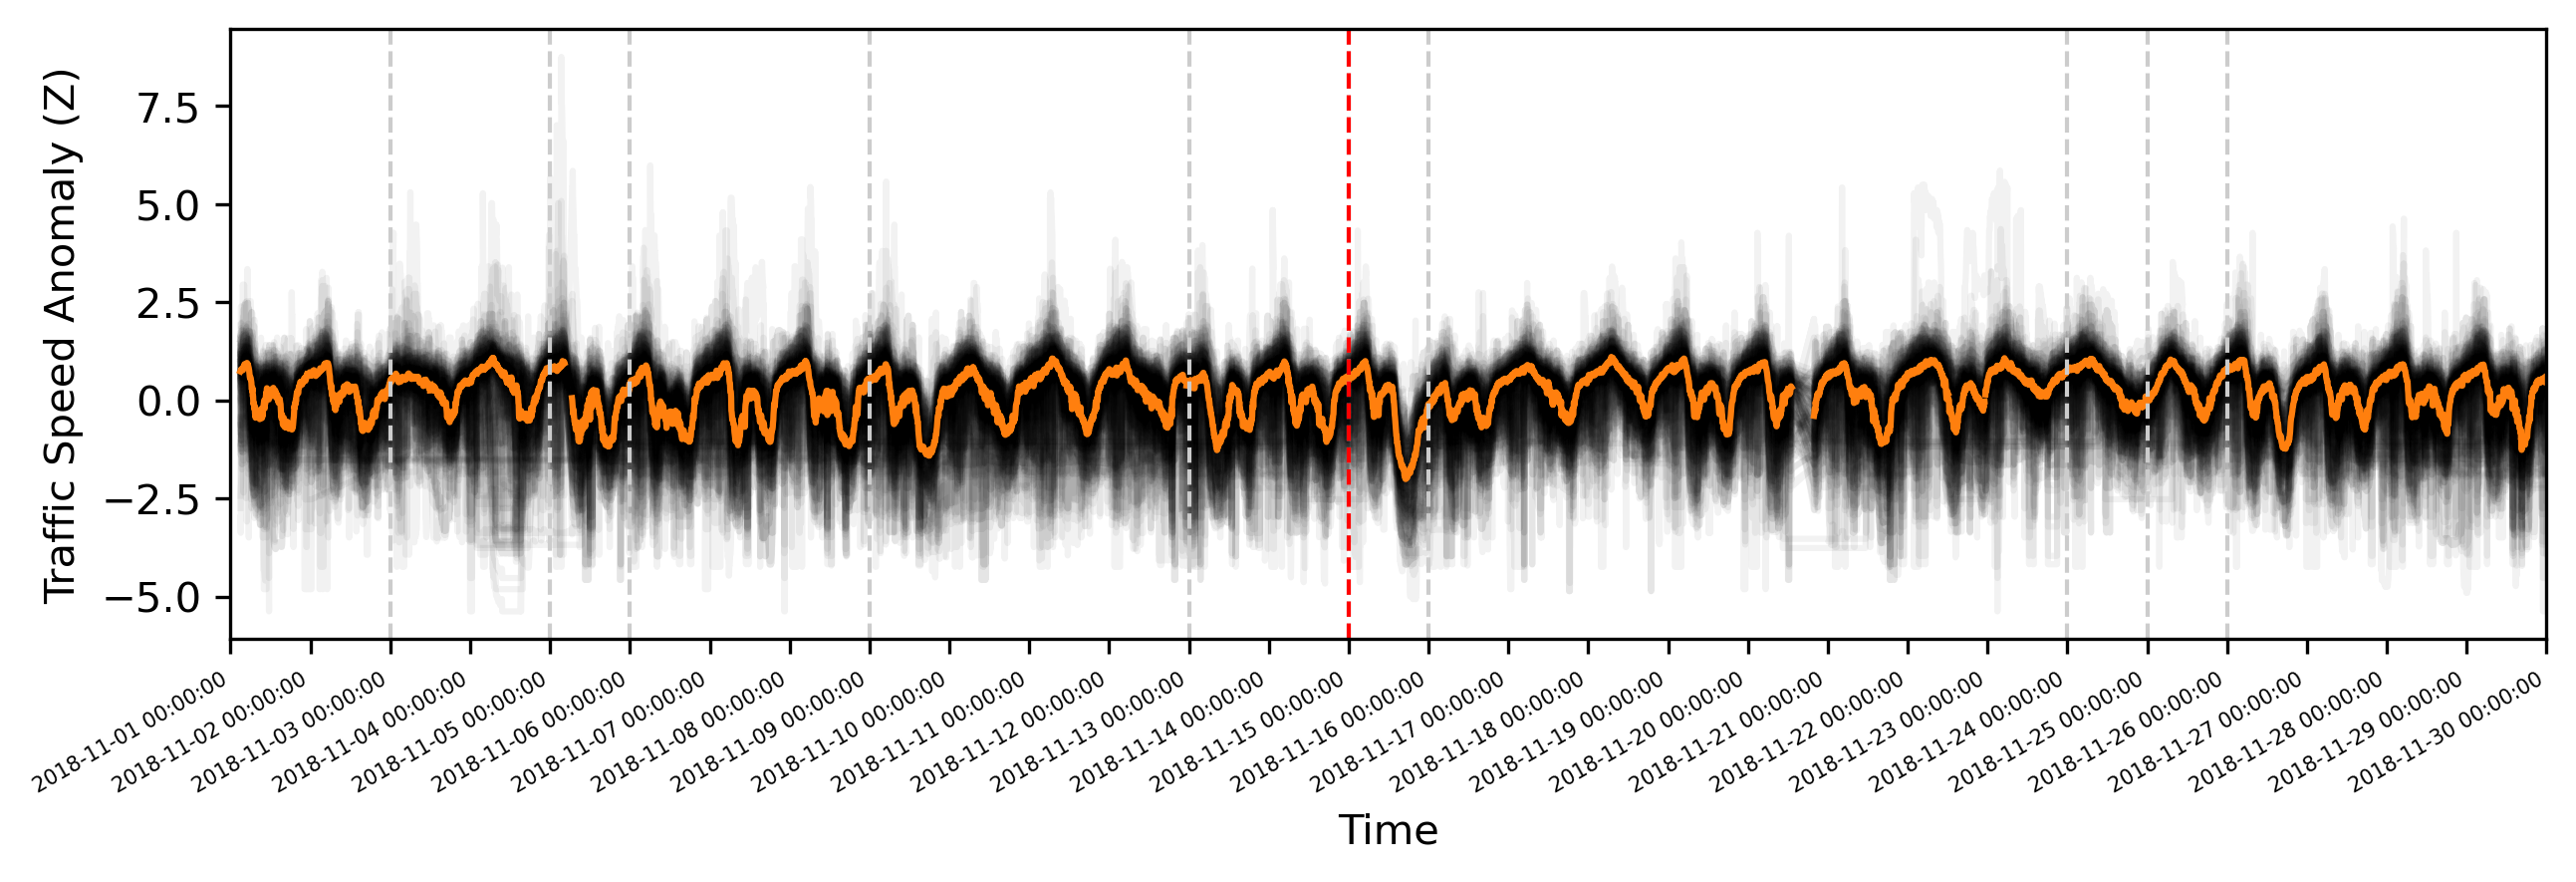

In [45]:
start = '2018-11-01'
end = '2018-11-30'

df_rs = plot_traffic_speed(df,df_weather,start,end,figsize = (10,3),ticks='1D')

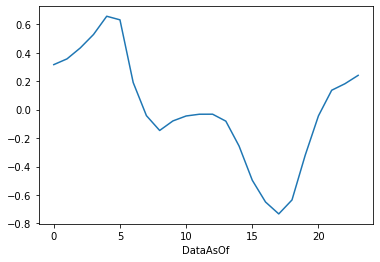

In [46]:
df_rs.groupby(df_rs.index.hour).mean().mean(axis=1).plot()

In [47]:
normal = df_rs.groupby(df_rs.index.hour).mean().median(axis=1)

Text(0.5, 1.0, 'November 2018 Traffic "Disaster"')

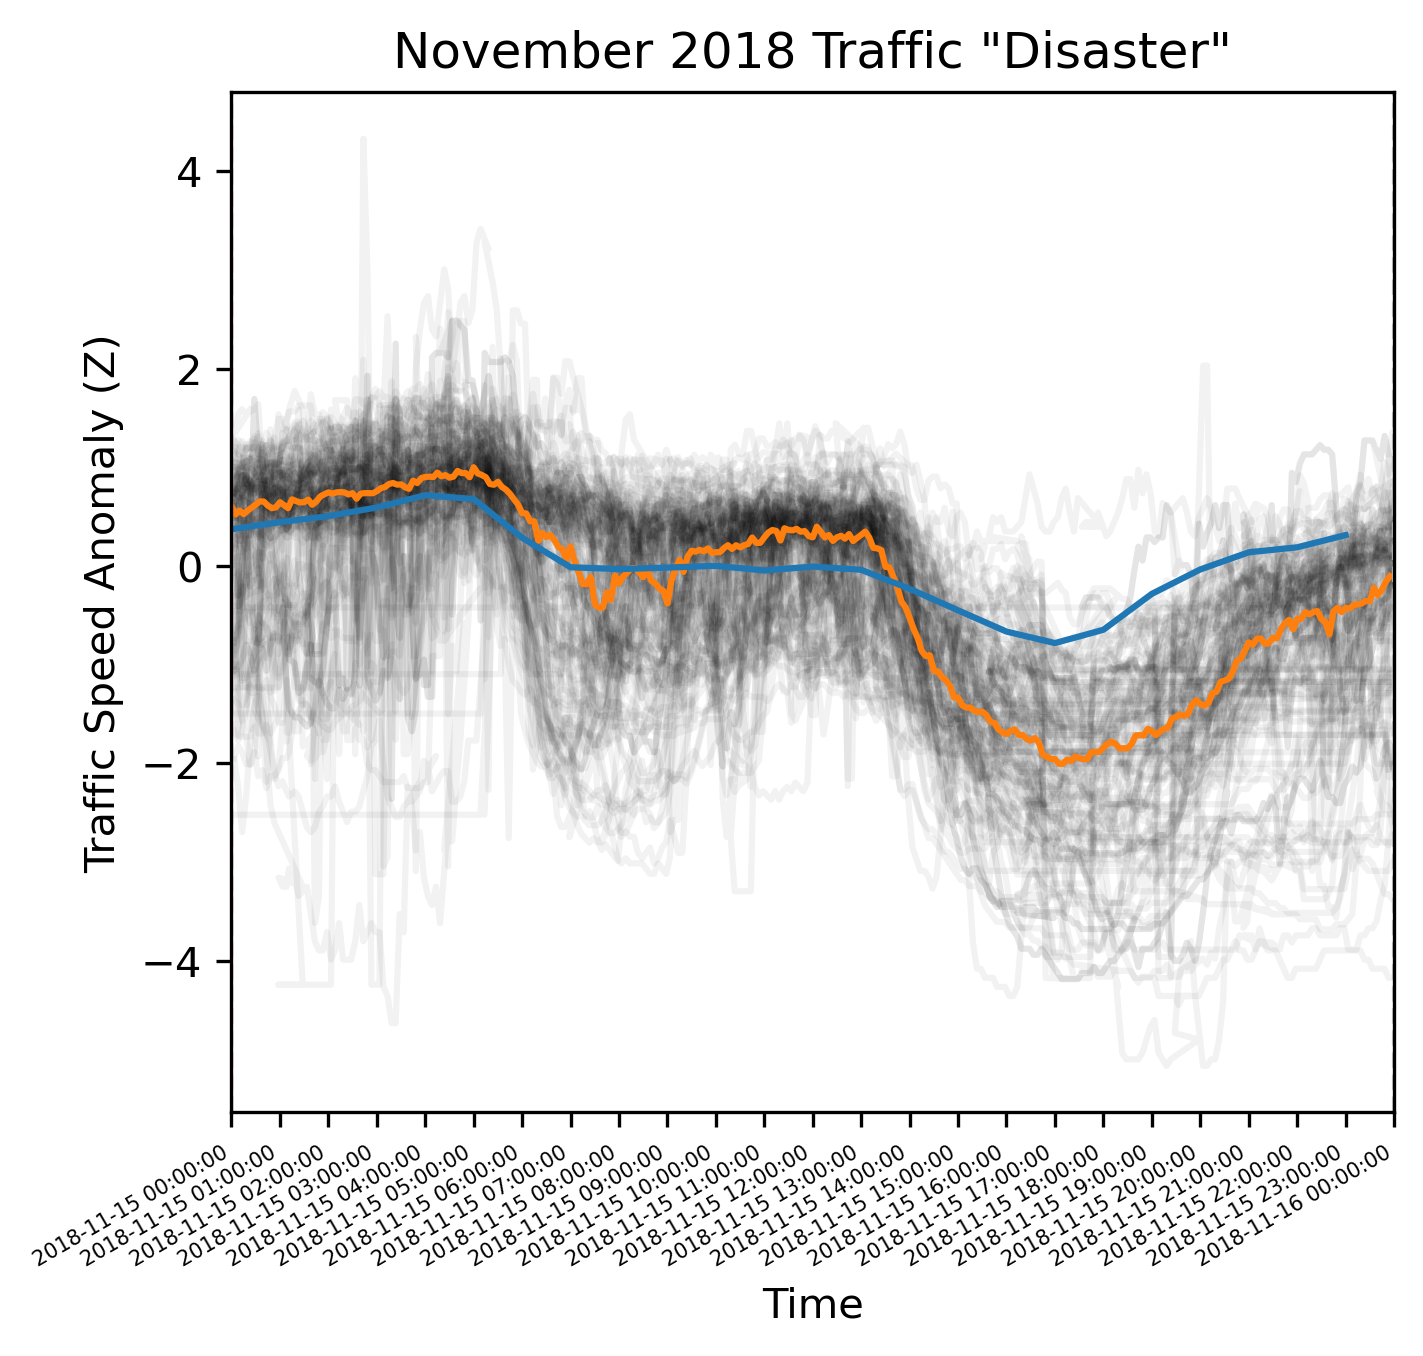

In [48]:
start = '2018-11-15'
end = '2018-11-16'

dates = pd.date_range(start=start,end=end,freq='1H')

df_rs_ig = plot_traffic_speed(df,df_weather,start,end,figsize = (5,5),ticks='1h')
plt.plot(dates[0:-1],normal,c='tab:blue')
plt.title('November 2018 Traffic "Disaster"')